# Rotation measure synthesis across the sky
For the theory behind this notebook, see `polarised_source_and_FEE_beam.ipynb`. Here, I'm just going to apply the method used to simulate Stokes parameters out of PSR J0835−4510, stick it at a bunch of different points in the primary beam, and grab the faraday depth function. I'll use the FEE beam, the RTS analytic beam, and beam gains of one with zero leakage.

First up, let's look at what our Stokes params look like for PSR J0835−4510.

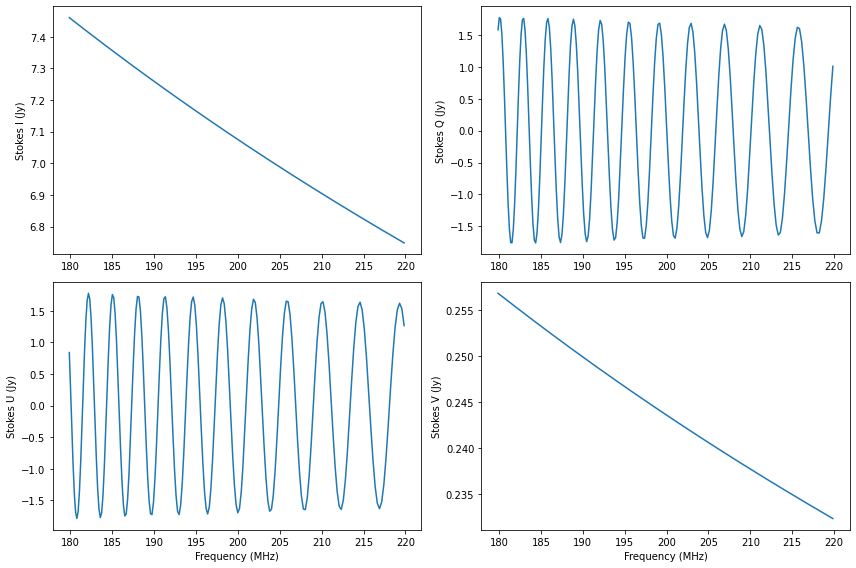

In [24]:
import polarised_source_and_FEE as psaf
import matplotlib.pyplot as plt
import numpy as np
import erfa
import mwa_hyperbeam

D2R = np.pi / 180.0
VELC = 299792458.0
MWA_LAT = -26.7033194444
MWA_LAT_RAD = MWA_LAT * D2R

frac_pol = 0.24
rm = 37.41
ref_I_Jy = 7.075
SI = -0.5
ref_V_Jy = 0.2436


##Cover a frequency range with 40MHz bandwidth
low_freq = 180e+6
high_freq = 220e+6
num_samples = 200

##sample evenly in wavelength squared
wavelen_low = 3e+8 / high_freq
wavelen_high = 3e+8 / low_freq
wavelens_squared = np.linspace(wavelen_low**2, wavelen_high**2,num_samples)

##convert back to frequencies as that makes the most sense in my head
freqs_hz = VELC / np.sqrt(wavelens_squared)

##This function applies Equations 9 and 10 above to derive the Q and U values
Is_Jy, Qs_Jy, Us_Jy = psaf.get_QU_complex(freqs_hz, rm, ref_I_Jy, SI, frac_pol)

##This function just applies a spectral index to extrapolate
##flux over frequencies
Vs_Jy = psaf.extrap_stokes(freqs_hz, ref_V_Jy, SI)


##Plot them up
fig, axs = plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(freqs_hz/1e+6, np.real(Is_Jy))
axs[0,1].plot(freqs_hz/1e+6, np.real(Qs_Jy))
axs[1,0].plot(freqs_hz/1e+6, np.real(Us_Jy))
axs[1,1].plot(freqs_hz/1e+6, np.real(Vs_Jy))

for ax in axs[1,:]: ax.set_xlabel('Frequency (MHz)')

labels = ['Stokes I', 'Stokes Q', 'Stokes U', 'Stokes V']

for label, ax in zip(labels, axs.flatten()): ax.set_ylabel(label + ' (Jy)')

plt.tight_layout()
plt.show()

# Beam gains of one
Ok, first off, let's run our RM sythnesis with beam gains of one and no leakage, where explicitly from the nomenclatue from the theory in `polarised_source_and_FEE_beam.ipynb`, I have set $g_x = g_y = 1$ and $Dx = D_y = 0$. The plot below shows how the gains vary with frequency, the recovered Stokes parameters, the Faraday Depth Function, and an illustrative all-sky beam plot. For this case, it's just one everywhere.

/home/jline/.local/lib/python3.6/site-packages/erfa/core.py:17787: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


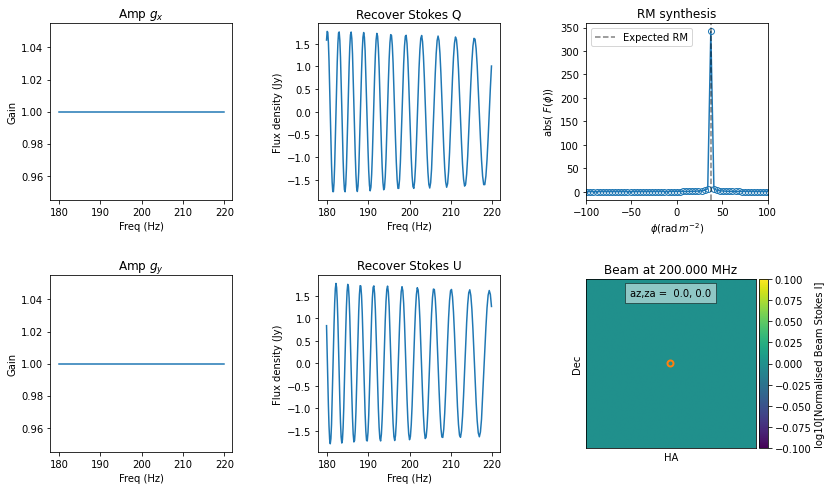

In [26]:
beam_model = 'unity'
ha_rad = 0
dec_rad = MWA_LAT_RAD

psaf.plot_rm_sythnesis(ha_rad, dec_rad, beam_model=beam_model,savefig=False,
                       low_freq=low_freq, high_freq=high_freq)

plt.show()

Ok sweet, we get a nice peak exactly where we expect in the FDF, and no nasty peak and zero, which means there is leagage going on. Let's look at the real beams now

## RTS analytic beam near zenith
Start off very close to zenith where leakage should be minimal:

/home/jline/.local/lib/python3.6/site-packages/erfa/core.py:17787: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


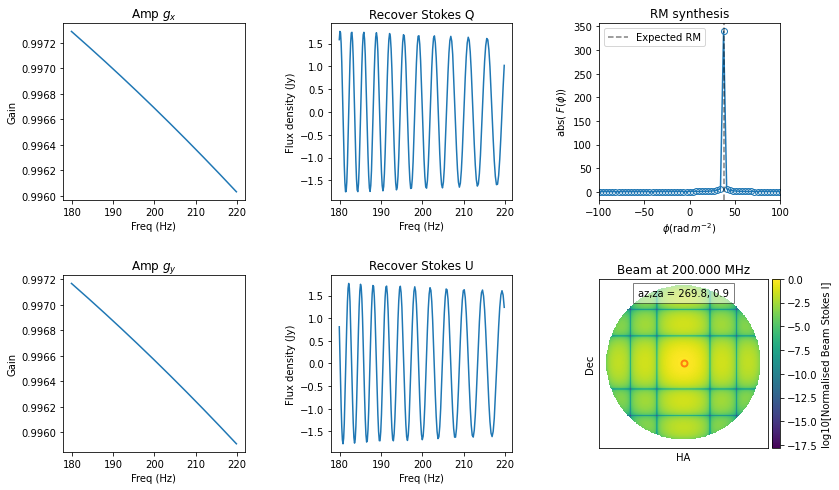

In [27]:
beam_model = 'rts'
ha_rad = 1*D2R
dec_rad = MWA_LAT_RAD

psaf.plot_rm_sythnesis(ha_rad, dec_rad, beam_model=beam_model,savefig=False,
                       low_freq=low_freq, high_freq=high_freq)

plt.show()

Cool, so nice and close to zenith, we see nearly exactly the same thing as a unity gain case. 

## Hyperbeam near zenith
Rinse and repear for `hyperbeam`

env: MWA_BEAM_FILE=/home/jline/software/useful/mwa_full_embedded_element_pattern.h5


/home/jline/.local/lib/python3.6/site-packages/erfa/core.py:17787: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


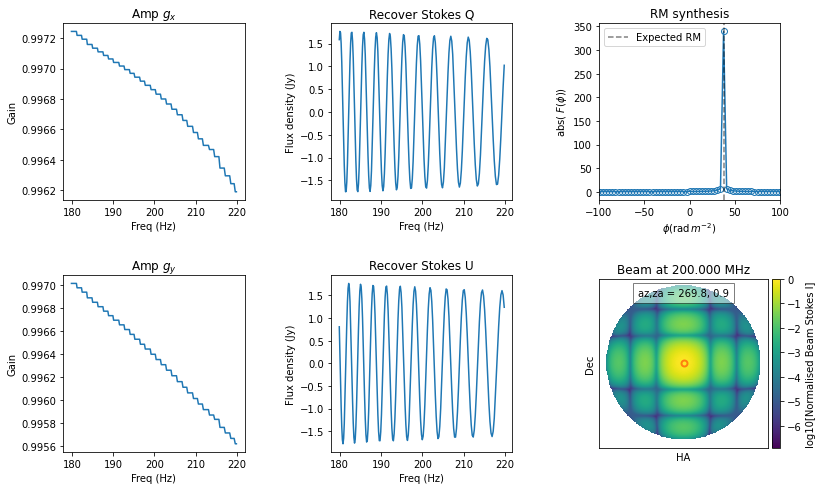

In [28]:
##Hyperbeam uses a environment variable to find the spherical harnmonincs,
##so set that here. You'll have to adjust this to your machine
%env MWA_BEAM_FILE=/home/jline/software/useful/mwa_full_embedded_element_pattern.h5
# %env MWA_BEAM_FILE=/home/jline/.local/lib/python3.8/site-packages/mwa_pb/data/mwa_full_embedded_element_pattern.h5

##Call it hyper_flip to signify that we are re-ordering the jones,
##and adding a negative sign to two of the array values
beam_model = 'hyper_flip'
ha_rad = 1*D2R
dec_rad = MWA_LAT_RAD

psaf.plot_rm_sythnesis(ha_rad, dec_rad, beam_model=beam_model,savefig=False,
                       low_freq=low_freq, high_freq=high_freq)

plt.show()

Ok, well we can see that the FEE beam is only at the native $1.28\,$MHz resolution, but we still recover the expected RM.

## RTS analytic off-zenith
Before, we saw far less leakage for the RTS analytic over the FEE beam for an off-zenith obs. Let's try and see why using the same settings here:


/home/jline/.local/lib/python3.6/site-packages/erfa/core.py:17787: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


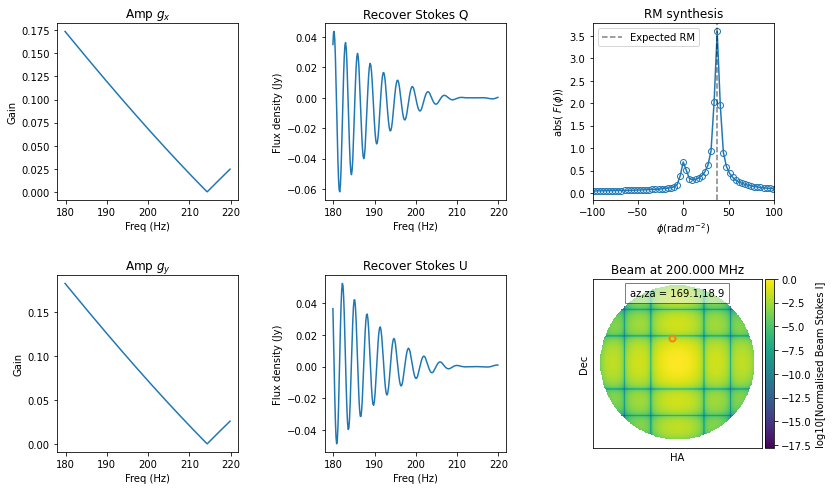

In [29]:
ra_rad = 128.84171*D2R
dec_rad = -45.16873*D2R

lst_rad = 123.84171*D2R
ha_rad = lst_rad - ra_rad

beam_model = 'rts'
psaf.plot_rm_sythnesis(ha_rad, dec_rad, beam_model=beam_model,savefig=False,
                       low_freq=low_freq, high_freq=high_freq)

plt.show()

## FEE beam off-zenith

/home/jline/.local/lib/python3.6/site-packages/erfa/core.py:17787: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


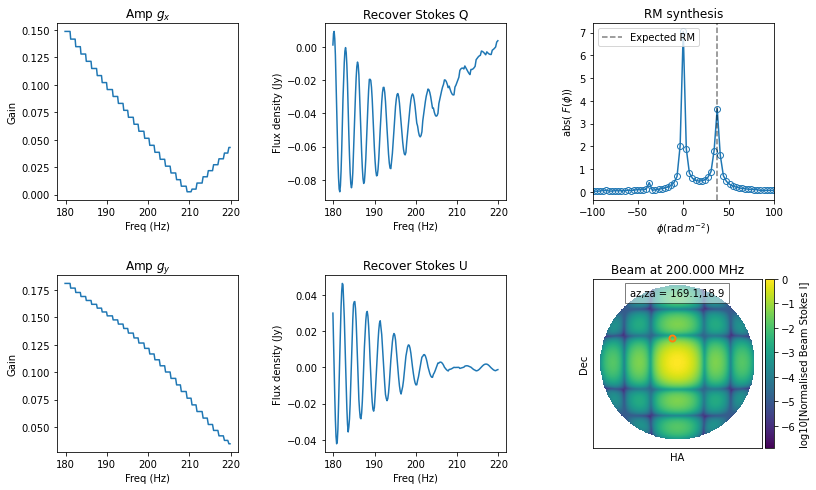

In [30]:
ra_rad = 128.84171*D2R
dec_rad = -45.16873*D2R

lst_rad = 123.84171*D2R
ha_rad = lst_rad - ra_rad

beam_model = 'hyper_flip'
psaf.plot_rm_sythnesis(ha_rad, dec_rad, beam_model=beam_model,savefig=False,
                       low_freq=low_freq, high_freq=high_freq)

plt.show()

Ok, so we're pretty much sat on a null here, and in the FEE beam, the two polarisations gains have different amplitude vs freq behavious, whereas both are very similar in the analytic beam. I think this is the cause of the worse leakage seen for this spot by the FEE beam.

## RTS analytic at a function of zenith angle
Next, let's make some movies of the response as we move away from zenith and through the sidelobes. I'll use the same Stokes params, and keep the source at a Declination of MWA_LAT, but slowly increase the hour angle to see what happens. Ignore the slew of erfa errors and `set_ylim` warnings, it should still work.

In [32]:
from IPython.display import Video

freq_cent = (low_freq + high_freq) / 2

beam_model = 'rts'
samps = 20

has_rad = np.linspace(0,89,samps)*D2R
decs_rad = np.ones(samps)*MWA_LAT_RAD

##Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

##I can't work out how to control video frames per sec without saving and then displaying
Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)


Ok, so in the main lobe, all is well, but by the time we get to edge of main lobe, things change with frequency quickly enough that we get some nasty leakge. By the time we `za` > 45 deg at the horizon, the zero RM peak dominates the FDF. How does this look for the FEE beam?

## FEE analytic at a function of zenith angle

In [33]:
beam_model = 'hyper_flip'
samps = 20

has_rad = np.linspace(0,89,samps)*D2R
decs_rad = np.ones(samps)*MWA_LAT_RAD

##Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)

Look pretty consistent with the RTS analytic beam, but has far worse leakage towards the nulls. Kinda of cool to see however that the leakage gets better again in the centre of the first sidelobe. 

## Unity gains across the sky
Let's do a sanity check and make sure our pipeline works for unity values across the sky, hopefully nothing changes with position.

In [36]:
beam_model = 'unity'
samps = 20

has_rad = np.linspace(0,89,samps)*D2R
decs_rad = np.ones(samps)*MWA_LAT_RAD

#Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)

Yup, as expected, nothing changes woot. 

## RTS different frequency chunk
Let's try things with different a frequency range

In [37]:
low_freq = 120e+6
high_freq = 160e+6

freq_cent = (low_freq + high_freq) / 2

beam_model = 'rts'
samps = 20

has_rad = np.linspace(0,89,samps)*D2R
decs_rad = np.ones(samps)*MWA_LAT_RAD

##Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

##I can't work out how to control video frames per sec without saving and then displaying
Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)

## FEE different freq
And for the FEE beam as well

In [38]:
low_freq = 120e+6
high_freq = 160e+6

freq_cent = (low_freq + high_freq) / 2

beam_model = 'hyper_flip'
samps = 20

has_rad = np.linspace(0,89,samps)*D2R
decs_rad = np.ones(samps)*MWA_LAT_RAD

##Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

##I can't work out how to control video frames per sec without saving and then displaying
Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)

## FEE beam at 300MHz

In [39]:
low_freq = 270e+6
high_freq = 320e+6

freq_cent = (low_freq + high_freq) / 2

beam_model = 'hyper_flip'
samps = 40

# has_rad = np.linspace(0,89,samps)*D2R
# decs_rad = np.ones(samps)*MWA_LAT_RAD

azs = np.ones(samps)*270*D2R
zas = np.linspace(0,89,samps)*D2R

has_rad, decs_rad = erfa.ae2hd(azs, np.pi/2 - zas, MWA_LAT_RAD)

##Uncomment this to create the movie for yourself
# psaf.rm_sythnesis_movie(has_rad, decs_rad, beam_model=beam_model, save=True,
#                         low_freq=low_freq, high_freq=high_freq)
# plt.close()

##I can't work out how to control video frames per sec without saving and then displaying
Video('{:s}_rm-on-sky_{:7.3f}MHz.mp4'.format(beam_model,freq_cent/1e+6),embed=True)